# Fluorescence Blinking Analysis

In [1]:
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fname = 'blinkers-salt-pepper-dynamic.tif'

In [3]:
video_raw = imageio.volread(fname)
video_raw.shape, video_raw.dtype

((4000, 150, 150), dtype('uint16'))

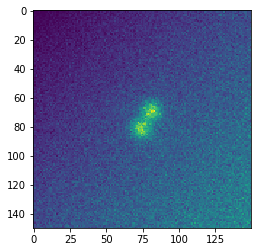

In [4]:
plt.imshow(video_raw[100])

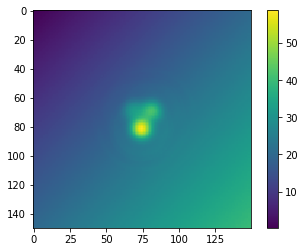

In [5]:
mean_frame = video_raw.mean(axis=0)  # the video temporal mean, axis 0 moves along frames

plt.imshow(mean_frame)
plt.colorbar();

> Note the space-variations of the background.

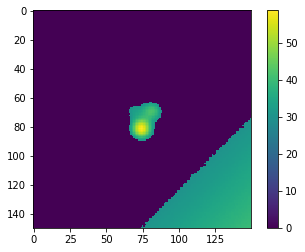

In [6]:
img = np.zeros_like(mean_frame)
mask = mean_frame > 30
img[mask] = mean_frame[mask]
plt.imshow(img)
plt.colorbar();

## Remove background

Background is an offset or a slow-varing signal that is not of interest.

- We can remove it with an high-pass filter.
- Gaussian filters are good choices for images
- An high-pass filtered image is the image minus the low-pass filtered image
- scipy has `gaussian_filter` (convolution of image with a gaussian kernel).

<div class="alert alert-info">
<b>Filters and Convolution</b> 
<p>
A convolution in space (or in time) is matematically equivalent to a mutiplication
of the spectrum by the Fourier transform of the convolution kernel.
The Fourier transfor of a Gaussian is still a Gaussian (it is the only function 
with this property!) but the sigma of the Gaussina in the frequency doamin (the bandwidth)
is inversely proportional to the sigma of the Gaussian in space. 
See [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).
</p>
</div>
<br> 
Let's use scipy's `gaussian_filter` to implement an high-pass filter:

In [7]:
from scipy import ndimage as ndi

We start with a low-pass filter:

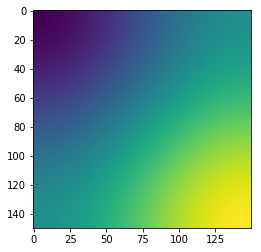

In [8]:
bg = ndi.filters.gaussian_filter(mean_frame, sigma=100)
plt.imshow(bg);

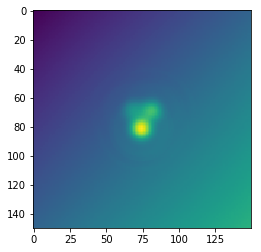

In [9]:
plt.imshow(mean_frame - bg);

Seems the background is roughly captured by the filter. But how do we choose an "optimal" `sigma`? 


In [10]:
from ipywidgets import interact

In [11]:
@interact(σ=(5, 100, 5), continuous_update=False)
def plot_frame(σ):
    plt.imshow(mean_frame - ndi.filters.gaussian_filter(mean_frame, sigma=σ))

A Jupyter Widget

> **NOTE** Choosing `sigma` is a trade off between good background rejection
> and not filtering interesting parts of the signal

In [12]:
sigma = 25
bg = ndi.filters.gaussian_filter(mean_frame, sigma=sigma)
video_bg = video_raw - bg

Wait a minute! Look at the last line.

We subtracted the background `bg` (a 2D array) from a video `video_raw` (3D arrays):

In [13]:
video_raw.shape, bg.shape

((4000, 150, 150), (150, 150))

In [14]:
video_bg.shape, video_bg.dtype

((4000, 150, 150), dtype('float64'))

> This magic is called **broadcasting** and is one cool property of numpy arrays.
> When shapes are different, they can still be matched.
> A simple example of broadcasting is adding a scalar to an array.
>
> You can read more about [broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html).

Going back to our video, after background subtraction a frame looks like:

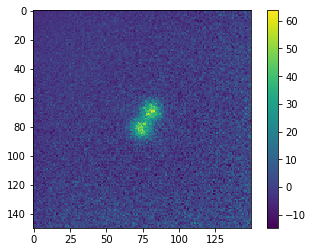

In [15]:
plt.imshow(video_bg[100])
plt.colorbar();

still preatty "noisy". 

## Denoising

<div class="alert alert-info">
<b>What is "noise"?</b> 
<p>
Noise is a random variation of the mean value of a pixel.
It is typically indipendent from pixel to pixel, meaning that
its spectrum contains the highest spatial frequencies.
</p>
</div>
<br> 

How can we get rid (or attenuate) the noise?

Well, we know Gaussian filters now. What we need is a low-pass filter
with very high bandwidth:

In [16]:
def plot_frame_sections(frame, x=80, y=60):
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    im = ax[-1].imshow(frame)
    ax[-1].axvline(x, color='white', lw=1)
    ax[-1].axhline(y, color='white', lw=1)
    ax[0].plot(frame[:, x]); 
    ax[0].set_xlabel(f'Section x = {x}')
    ax[1].plot(frame[y, :])
    ax[1].set_xlabel(f'Section y = {y}')
    fig.colorbar(im);

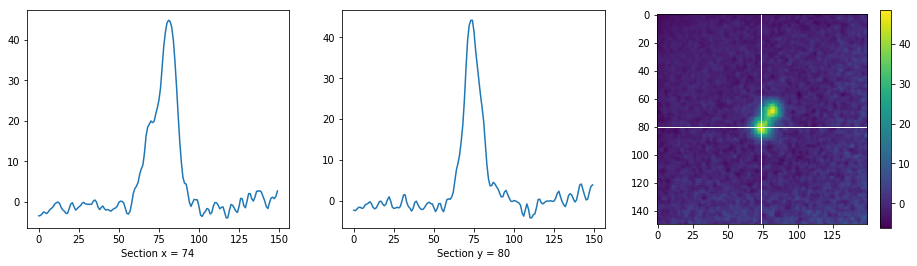

In [17]:
img_gauss_nr = ndi.filters.gaussian_filter(video_bg[100], sigma=1)
plot_frame_sections(img_gauss_nr, x=74, y=80)

Pretty good. We can use another trick that preservers the signal better especially 
with *salt and pepper* noise (i.e. when some pixels are more noisy than others):

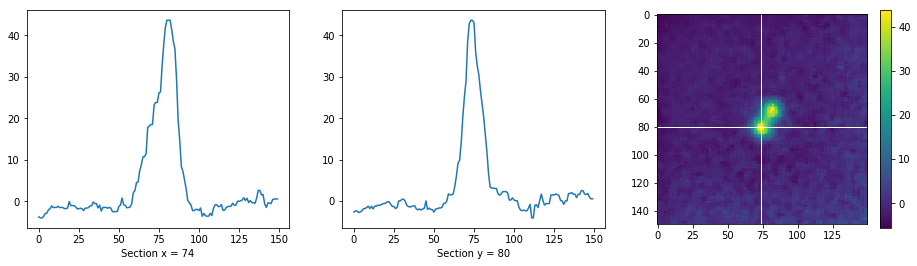

In [18]:
img_median_nr = ndi.median_filter(video_bg[100], 5)
plot_frame_sections(img_median_nr, x=74, y=80)

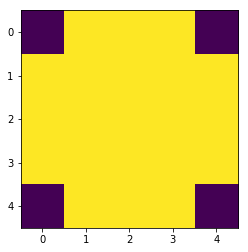

In [19]:
footprint = np.ones((5, 5), dtype=bool)
footprint[0,0] = footprint[0,-1] = footprint[-1, 0] = footprint[-1, -1] = False
plt.imshow(footprint)

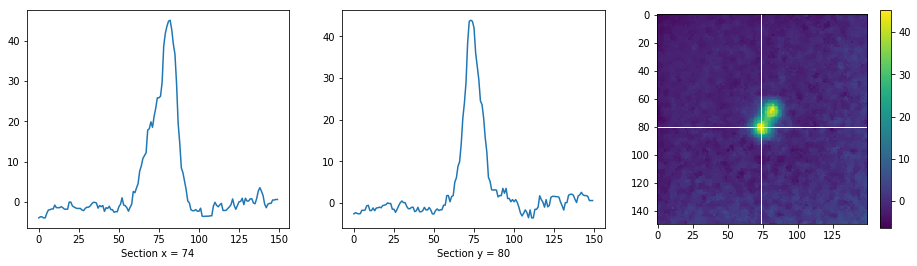

In [20]:
img_median_nr = ndi.median_filter(video_bg[100], footprint=footprint)
plot_frame_sections(img_median_nr, x=74, y=80)

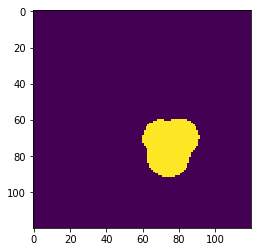

In [21]:
mask = video_bg.mean(0) > 1
plt.imshow(mask[:120, :120])

In [22]:
frame_crop = ndi.find_objects(mask[:120, :120])[0]
frame_crop

(slice(60, 92, None), slice(60, 92, None))

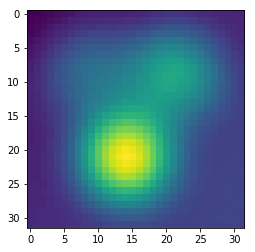

In [23]:
plt.imshow(mean_frame[frame_crop])

How do we crop the entire video?

In [24]:
video_crop = video_bg[:, frame_crop[0], frame_crop[1]]
video_crop.shape

(4000, 32, 32)

How can we do it for all the frames?

Here is a little drammatization of how different users would do it:

**MATLAB User**: I would do a simple for loop:

In [25]:
video_corr = np.zeros_like(video_crop)
for i, frame in enumerate(video_crop):
    video_corr[i] = ndi.median_filter(frame, 5)
print(video_corr.shape, video_corr.dtype)

(4000, 32, 32) float64


**Intermediate Python User**: Ar-ehm, actually in python you don't need to use an index `i`
for looping, you can loop frame-by-frame and append the result to a list on the go:

**MATLAB User**: Interesting, but your solution is slower uses 
double the memory.

**Intermediate Python User**: *(pretend she didn't hear, then utters)* Python is great!

**Python Beginner**: Sorry, I pass. Still didn't reach the for-loop in the [python tutorial](https://docs.python.org/3/tutorial/).

**Python Expert** This a perfect case for [list comprehension](https://www.google.com/search?q=list+comprehension+python).

**MATLAB User**: Neat, I have never seen something like that.
Still your solution uses double the ram and is the slower than mine.

> **Design Pattern**: Every time we build a list in relatively short for-loop
> we can use list comhension and avoid temporary variables.

# Blinking trajectories

In [26]:
video = video_corr
mean_frame = video.mean(0)

In [27]:
video.shape

(4000, 32, 32)

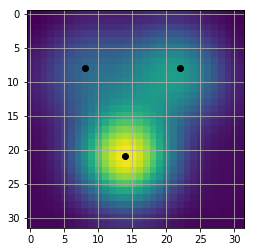

In [28]:
plt.imshow(mean_frame)
plt.plot([8, 14, 22], [8, 21, 8], 'ok')
plt.grid()

In [29]:
ROIs_1point = [(8, 8), 
               (14, 21), 
               (22, 8)]

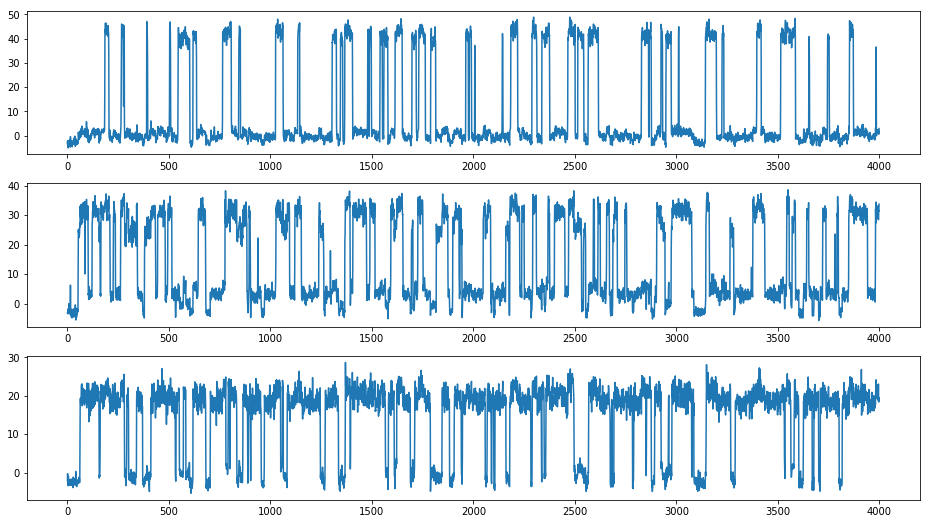

In [30]:
ROIs = ROIs_1point
video = video_corr

fig, AX = plt.subplots(len(ROIs), 1, figsize=(16, 3*len(ROIs)))
for ax, roi in zip(AX, ROIs):
    ax.plot(video[(slice(None), *roi)])

# Segmentation

When we have low-concentration single emitter blionking, [SOFI](https://en.wikipedia.org/wiki/Super-resolution_optical_fluctuation_imaging) can give image above the resolution limit.

SOFI can be compute to high orders and include cross-correlation between pixels.
But, the 2nd order SOFI is simply the time-domain autocorrelation of each pixel
in the video compute at time-lag = 0. The AFC(0) = Variance, so we can compute a
superresolved image by taking the variance of each pixels in the video.

In [31]:
video = video_corr

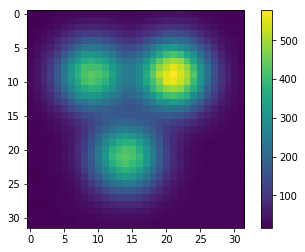

In [32]:
frame = video_raw.var(0)
plt.imshow(frame[frame_crop])
plt.colorbar()

The simplest form of segmentation is histogram-based. We plot the image histogram
and we use an intensityt threshold so select connected regions of interest (ROIs).

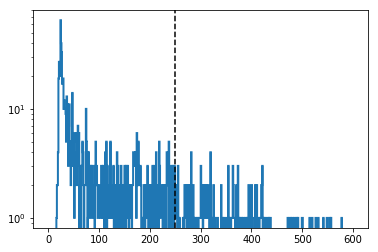

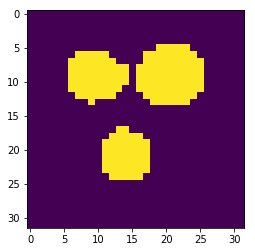

In [33]:
th = 250
binary_mask = frame[frame_crop] > th

plt.hist(frame[frame_crop].ravel(), bins=np.arange(600), histtype='step', lw=2);
plt.axvline(th, color='k', ls='--')
plt.yscale('log')

plt.figure()
plt.imshow(binary_mask)

Let's plot the frame values, clipped by the mask:

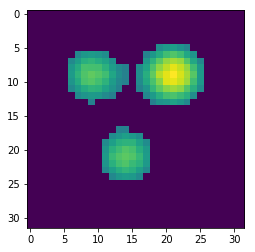

In [34]:
frame_clip = np.zeros_like(frame[frame_crop])
frame_clip[binary_mask] = frame[frame_crop][binary_mask]

plt.figure()
plt.imshow(frame_clip)

Once we have a binary image with all the ROIs we can label them:

In [35]:
img_labels, nlabels = ndi.measurements.label(binary_mask)
labels = np.arange(1, nlabels+1)
nlabels, labels

(3, array([1, 2, 3]))

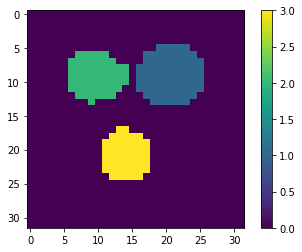

In [36]:
plt.imshow(img_labels)
plt.colorbar()

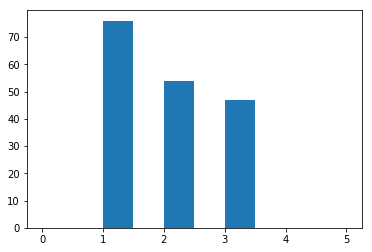

In [37]:
plt.hist(img_labels[img_labels > 0], range=(0, 5));

Now each ROI have a different label. Label 0 is the background and label 1 to 3 are
the ROIs of the 3 blinkers.

In order to use these ROIs to select pixels in the original array,
we need to be able to use then as index.


In [38]:
ROIs_area = [img_labels == label for label in range(1, nlabels+1)]
ROIs_area

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, Fa

In [39]:
roi = ROIs_area[0]
video[:, roi].shape

(4000, 76)

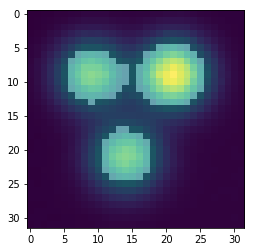

In [40]:
test = np.zeros_like(frame[frame_crop])
plt.imshow(frame[frame_crop])
for roi in ROIs_area:
    test[roi] = 1
plt.imshow(test, cmap='gray', alpha=0.3)

# Trajectories analysis

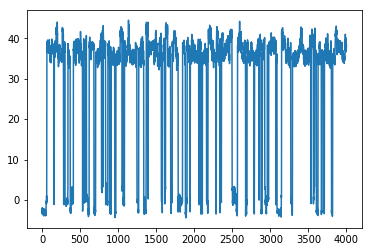

In [41]:
plt.plot(video[:, roi].mean(1))

When we selected the blinkers with single points we used a different order. Let's fix it:

In [42]:
ROIs_1point[0], ROIs_1point[1] = ROIs_1point[1], ROIs_1point[0]

This compares blinking trajectories obtained with a single point or with the "area" ROI:

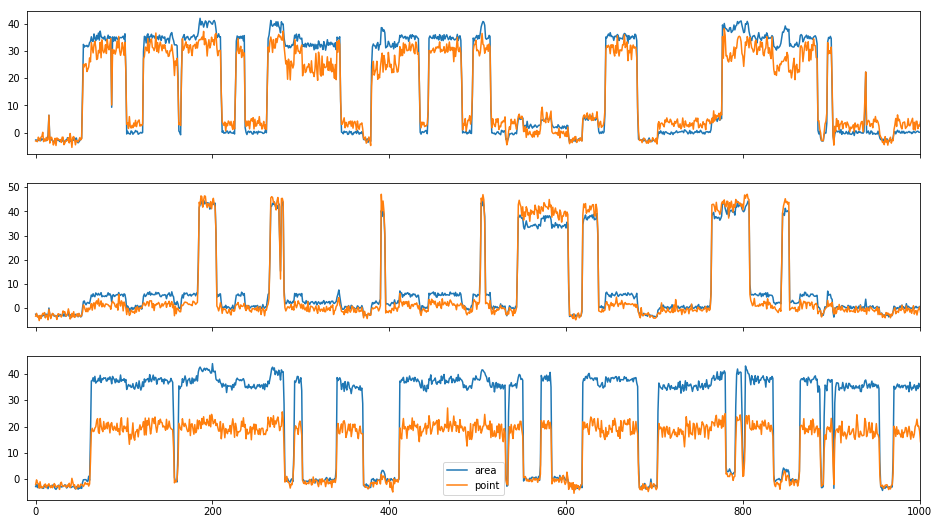

In [43]:
ROIs = ROIs_area
video = video_corr

fig, AX = plt.subplots(len(ROIs), 1, figsize=(16, 3*len(ROIs)), sharex=True)
for ax, roi, roi1 in zip(AX, ROIs, ROIs_1point):
    ax.plot(video[:, roi].mean(1), label='area')
    ax.plot(video[:, roi1[0], roi1[1]], label='point')
ax.set_xlim(-10, 1000)
plt.legend()

As expected the signal is higher when using an the "area" ROIs.

Now, let's use a threshold to select the ON and OFF periods:

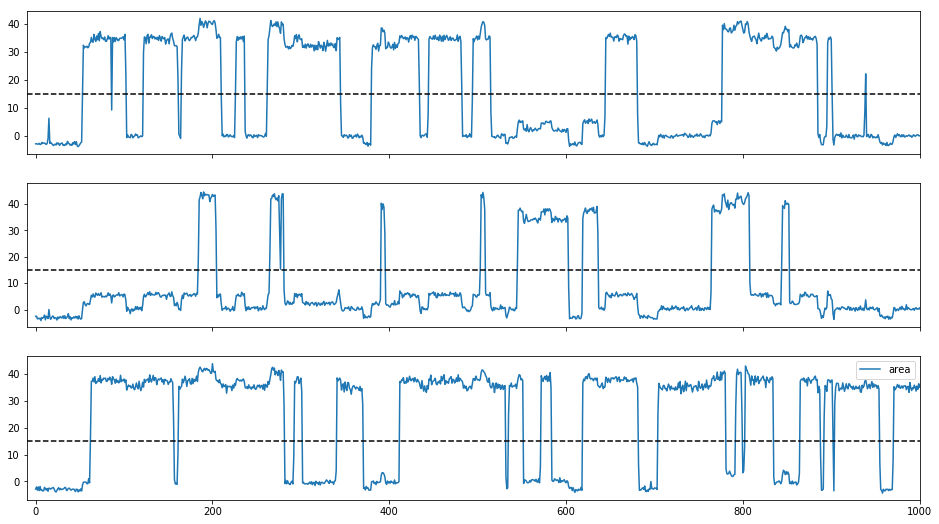

In [44]:
ROIs = ROIs_area
video = video_corr

fig, AX = plt.subplots(len(ROIs), 1, figsize=(16, 3*len(ROIs)), sharex=True)
for ax, roi in zip(AX, ROIs):
    ax.plot(video[:, roi].mean(1), label='area')
    ax.axhline(15, ls='--', color='k')
ax.set_xlim(-10, 1000)
plt.legend()

Let's plot the binary blinking trajectories together with the fluorescence trajectories:

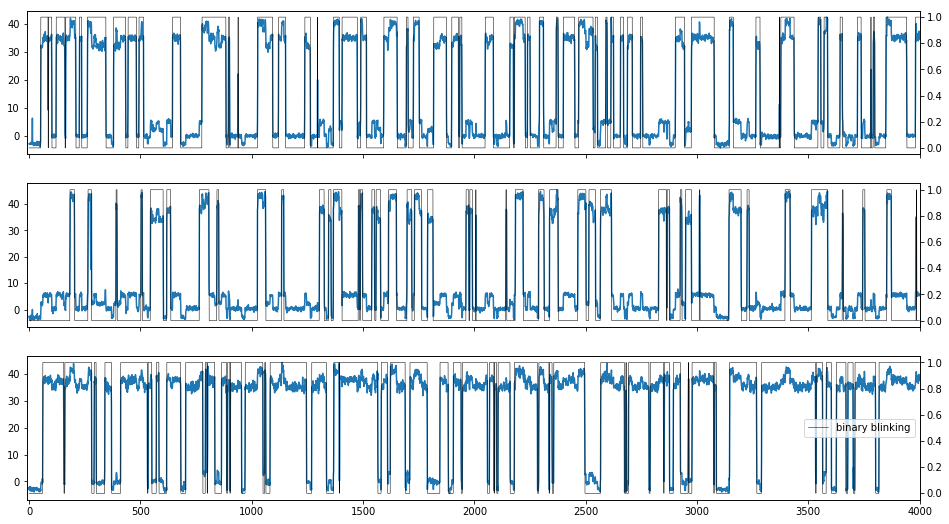

In [45]:
th = 10
ROIs = ROIs_area
video = video_corr

fig, AX = plt.subplots(len(ROIs), 1, figsize=(16, 3*len(ROIs)), sharex=True)
AX2 = [ax.twinx() for ax in AX]
for ax, ax2, roi in zip(AX, AX2, ROIs):
    timetrace = video[:, roi].mean(1)
    ax.plot(timetrace, label='timetrace')
    ax2.plot(timetrace > th, label='binary blinking', color='k', lw=0.5)
ax.set_xlim(-10, 4000)
plt.legend()

## Find start-stop index of each state

So far we got the blinking trajectories as a boolean trajectories.

We would like also to find start and stop time of each ON (or OFF) state.
To do that, I wrote a little function in the file `blinking.py`.
We can load it with:

In [46]:
%run blinking.py

This is different from importing because is like writing the function
in the notebook. Practically, the difference is that is you can change 
and re-run the previous cell to load the new version.

Let's look a the documentation of the function we will use:

In [47]:
help(compute_states_startstop)

Help on function compute_states_startstop in module __main__:

compute_states_startstop(blink_trajectory)
    Compute start-stop times of residency in a state.
    
    This function takes as input an array of booleans `blink_trajectory`
    and computes the start-stop times for all the time ranges where the state
    is "on", i.e. where `blink_trajectory` is True.
    
    Implementation:
        This version goes through `blink_trajectory` array element 
        by element using a for-loop which is slow.
    
    Arguments:
        blink_trajectory (array of bool): "blinking trajectory", telling
            whether the state is populated (True) or not (False) as a
            function of time.
    
    Return:
        A list of 3-element tuples (start, stop, label), one for each set of
        consecutive time-points in the trajectory where the state is "on".



In [48]:
blink_traj = (timetrace > th)

In [49]:
df = compute_states_startstop(blink_traj)
df.head()

,istart,istop
0,62,157
1,161,282
2,293,302
3,341,371
4,412,532


The result `df` is a pandas `DataFrame`, whose first few rows are shown above.

<div class="alert alert-info">
<b>What is a pandas DataFrame</b> 
<p>
Pandas <code>DataFrame</code> is a table-like container, or columnar data container.
The difference with a numpy array is that a pandas <code>DataFrame</code> can have columns 
of different types. Also rows or columns can have names. 
You can have one numeric column and one string type function 
and so on. On the contrary, in a numpy array all elements have the same type, and
axis (i.e. columns) have no "names".
<br> <br> 
Additionally <code>DataFrame</code> have methods for quick plotting and grouping.
</p>
</div>
<br> 

Let's write some test to verify the function that results are consistent.
This is called "defensive programming",
it is one of the most important techniques in scientific computing.

In python we can write a test just using `assert`:

In [50]:
assert (df.istart < df.istop).all()

In [51]:
assert (df.istop > 0).all()

In [52]:
assert (df.istop < video_raw.shape[0]).all()

Here we compute a `DataFrame` for each blinker and put them in a list `df_list`:

In [53]:
th = 20
df_list = []
for label, roi in zip(labels, ROIs_area):
    print(f'- Extracting trajectories for ROI {label}')
    timetrace = video[:, roi].mean(1)
    on_states_df = compute_states_startstop(timetrace > th)
    df_list.append(on_states_df)
len(df_list)

- Extracting trajectories for ROI 1
- Extracting trajectories for ROI 2
- Extracting trajectories for ROI 3


3

In [54]:
df_list[0].head()

,istart,istop
0,54,86
1,87,103
2,122,162
3,165,210
4,227,237


## Concatenating DataFrames

It is easier is we concatenate all the start-stop DataFrame in
a single DataFrame. When doing so we should preserve the 
blinker information (the label).

One way of doing it is adding a new column indicationg the label:

In [55]:
for label, df in zip(labels, df_list):
    df['label'] = label  # adds a new column
on_states_df = pd.concat(df_list)
on_states_df.head()

,istart,istop,label
0,54,86,1
1,87,103,1
2,122,162,1
3,165,210,1
4,227,237,1


In [56]:
# remove the label column for the sake of the next example
[df.drop('label', axis=1, inplace=True) for df in df_list];

Concatenating DataFrames and add "labels" to differentiate
different parts is such a common operation that we can do it
in one step

In [57]:
on_states_df = pd.concat(df_list, keys=labels)
on_states_df.index.names = ['label', 'cycle']
on_states_df.reset_index(0, inplace=True)
on_states_df.head()

,label,istart,istop
cycle,,,
0,1,54,86
1,1,87,103
2,1,122,162
3,1,165,210
4,1,227,237


In [58]:
on_states_df['duration'] = on_states_df['istop'] - on_states_df['istart']
on_states_df.sample(5)

,label,istart,istop,duration
cycle,,,,
29,2,2466,2502,36
31,1,2368,2376,8
26,1,2049,2086,37
47,1,3643,3653,10
0,1,54,86,32


## Plotting DataFrames

Once we have all the data in one `DataFrame`, plotting is a breeze:

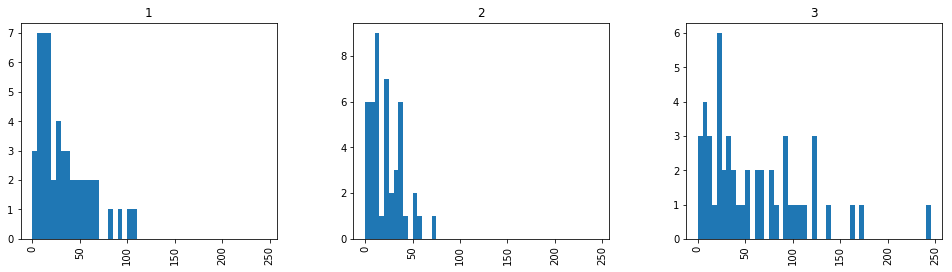

In [59]:
on_states_df.hist(figsize=(16, 4), column='duration', by='label', sharex=True,
                  layout=(1, 3), bins=range(0, 250, 5));

Thanks to the `by` argument, histograms are reproduced for "label".

Another package for plotting a `DataFrame` is `seaborn`:

In [60]:
import seaborn as sns
sns.__version__

'0.8.1'

We can make a factor-plot showing mean and standard deviation of each group:

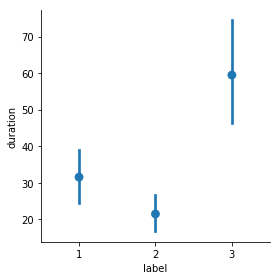

In [61]:
sns.factorplot(y='duration', data=on_states_df, x='label', linestyles='')

Or we can do factor-histograms as before. Here I also add some more
customization adding a vertical line for the mean to each plot:

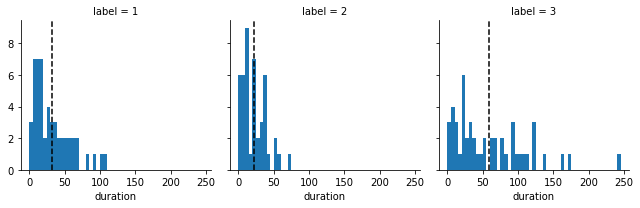

In [62]:
def _plot(data, color=None):
    plt.axvline(data.mean(), ls='--', color='k')

g = sns.FacetGrid(on_states_df, col="label")
g.map(plt.hist, 'duration', bins=np.arange(0, 250, 5))
g.map(_plot, 'duration')

The idea is that the `DataFrame` column passed to `col` is used to "stratify"
the plot. 

> **HINT**: Try changing `col` to `row` or to `hue` in the plot above and see what happens.

## Group-by

In the plot above we have implicitly grouped rows of the DataFrame by 
a given column (label) and used the result to make the plot.

We can perform the "group-by" operation explicitly:

In [63]:
on_states_grp = on_states_df.groupby('label')

In [64]:
on_states_grp['duration'].count()

label
1    52
2    45
3    49
Name: duration, dtype: int64

In [65]:
on_states_grp['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1,52.0,31.576923,26.599680,1.0,11.75,23.5,46.0,108.0
2,45.0,21.511111,16.925804,1.0,9.00,20.0,34.0,73.0
3,49.0,59.469388,51.908614,3.0,23.00,43.0,93.0,242.0


In [66]:
on_states_grp['duration'].mean()

label
1    31.576923
2    21.511111
3    59.469388
Name: duration, dtype: float64

> **HINT**: You can read more about the [split-appy-compine workflow](https://pandas.pydata.org/pandas-docs/stable/groupby.html) in the official pandas docs.

## Combining ON and OFF states

As a last example we extent the code we used to compute the ON states
including also the OFF periods.

We can use a single DataFrame with a new column that will tell
whether the state is ON or OFF:

In [67]:
th = 20
on_states_list, off_states_list = [], []
for label, roi in zip(labels, ROIs_area):
    print(f'- Extracting trajectories for ROI {label}')
    timetrace = video[:, roi].mean(1)
    on_states_list.append(compute_states_startstop(timetrace > th))
    off_states_list.append(compute_states_startstop(timetrace <= th))

for state, df_list in zip(['on', 'off'], [on_states_list, off_states_list]):
    for label, df in zip(labels, df_list):
        df['label'] = label
        df['state'] = state

states_df = pd.concat(on_states_list + off_states_list)
states_df['duration'] =  states_df['istop'] - states_df['istart']
states_df.sample(10)

- Extracting trajectories for ROI 1
- Extracting trajectories for ROI 2
- Extracting trajectories for ROI 3


,istart,istop,label,state,duration
15,1488,1498,2,on,10
21,1654,1695,1,off,41
33,2866,2877,2,on,11
27,2289,2313,2,on,24
11,896,901,1,on,5
47,3588,3643,1,off,55
35,2684,2693,3,off,9
31,2338,2349,3,on,11
37,3144,3198,2,on,54
5,535,552,3,on,17


Identical result can be obtained with the second approach to concatenation.
Use the one that you prefer:

In [68]:
th = 20
on_states_list, off_states_list = [], []
for label, roi in zip(labels, ROIs_area):
    print(f'- Extracting trajectories for ROI {label}')
    timetrace = video[:, roi].mean(1)
    on_states_list.append(compute_states_startstop(timetrace > th))
    off_states_list.append(compute_states_startstop(timetrace <= th))

states_df = pd.concat([pd.concat(on_states_list, keys=labels), 
                       pd.concat(off_states_list, keys=labels)],
                      keys=('on', 'off'))
states_df.index.names = ['state', 'label', 'cycle']
states_df['duration'] =  states_df['istop'] - states_df['istart']
states_df.sample(10)

- Extracting trajectories for ROI 1
- Extracting trajectories for ROI 2
- Extracting trajectories for ROI 3


istart  istop  duration
state label cycle                         
on    3     39       2961   2964         3
off   2     39       3235   3397       162
      1     3         162    165         3
      3     19       1394   1396         2
on    3     9         792    800         8
off   3     44       3533   3536         3
on    2     43       3853   3873        20
off   1     26       1944   2049       105
            49       3738   3782        44
            45       3436   3544       108

## Plotting DataFrame vs 2 variables

We can now "stratify" or "plot by group" of two variables: blinker label and state (on or off).

The plot is very similar, we just use both `row` and `col` argument to
`FacetGrid`:

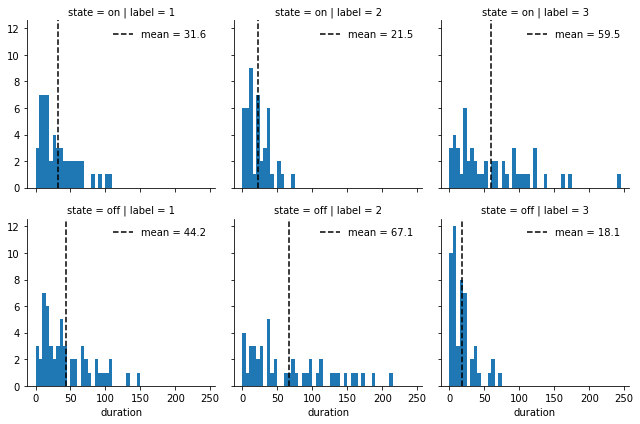

In [69]:
def _plot(data, color=None):
    plt.axvline(data.mean(), ls='--', color='k', 
                label=f'mean = {data.mean():.1f}')
    plt.legend()

g = sns.FacetGrid(states_df.reset_index((0, 1)), col="label", row='state')
g.map(plt.hist, 'duration', bins=np.arange(0, 250, 5))
g.map(_plot, 'duration')
for a in g.axes.ravel():
    a.legend(frameon=False)

To have one histogram per  label and differentiate between state ON and OFF
by color we just use `hue`:

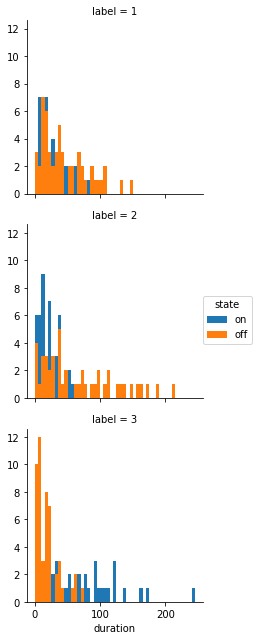

In [70]:
g = sns.FacetGrid(states_df.reset_index((0, 1)), row="label", hue='state')
g.map(plt.hist, 'duration', bins=np.arange(0, 250, 5)).add_legend()

Finally, as we see from the plots binkers have different mean ON or OFF times.

We can get a mean for ON and OFF times for each blinker with a single group-by
operation:

In [71]:
states_grp = states_df.groupby(['label', 'state'])
states_grp['duration'].mean()

label  state
1      on       31.576923
       off      44.150943
2      on       21.511111
       off      67.066667
3      on       59.469388
       off      18.080000
Name: duration, dtype: float64

Tutorial ends here! 

The rest is a bunch or references.

---

# Installation

You can run this analysis on your own computer by installing the scientific python
distribution Anaconda (all packages are open source).
All the packages needed are installed in the base distribution.

- https://www.anaconda.com/


# References

Each project/library used here has its own well-curated documentation.
(see [next section](#Official-reference-documentation)).
However, these docs are not the best for learning the
big picture of how to use and combine these library together.

To understand the "big picture" more general lectures, tutorials 
or blog posts are the to-go resource (see [this section](#Books/Tutorials/Blogs)).

Finally, when stuck on a problem it is fundamental to learn how to use google.
The Q/A website StackOverflow is a mine of virtally any question regarding computing.
The difference between a skilled and a beginner programmer is largely
in knowing what keyword to use to search for a specific information.


## Official reference documentation

The reference documentation of each library is the "reference" source
when checking how to use functions. However, when starting it is usefull
to read other sources that give more an overview of how to combine the
different packages together.

- [Numpy](http://www.numpy.org/)
> Contains: ND-arrays, random numbers, linear algebra, FFT

- [Scipy](https://www.scipy.org/)
> Contains: image analysis, signal processing, integration, optimization/fitting, 
> random distributions, special functions, and more.


- [Matplotlib](https://matplotlib.org/)
> "The 20,000 lb gorilla of python visualization." [Citation source](https://dsaber.com/2016/10/02/a-dramatic-tour-through-pythons-data-visualization-landscape-including-ggplot-and-altair/).

- [Seaborn](https://seaborn.pydata.org/)
> Statistical plots made easy

- [Pandas](https://pandas.pydata.org/)
> The core data-science library. `Series` (1D) and `DataFrame` are the foundation
> of working with columnar data. Enables "tidy data" workflows
> and simplifies handling complex an heterogeneous data.

### Additional packages

These packages were not used here but are worth mentioning. 

- [scikit-image](http://scikit-image.org/)

A robust suite of image-analysis algorithms beyond what is offered by scipy.

- [scikit-learn](http://scikit-learn.org/)

The corner-stone library for machine learning.


## Books/Tutorials/Blogs 

### Complete courses:

- [Scipy Lecture Note](http://www.scipy-lectures.org/)

A very comprehensive "book" on scientific computing in python from the basics 
to expert level. Writtern by veterans of the scientific python community.

- [From Python to Numpy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)

From Nicolas Rougier, this tutorial shows impressive animations of classical problems
such as game of life, boids simulations, diffusion-reaction simualtion and more.
It show-cases advanced numpy techniques.

### Pandas, tidy data and viz

- [Modern Pandas](https://tomaugspurger.github.io/modern-1-intro.html)

This is a series of blog post from Pandas's core developer Tom Augspurger, which
introduces the reader to modern pandas idioms using examples. This is a true gem,
read it, and try to understand the concepts and run the examples.
You'll probably forget the syntax soon, but you'll know how to find it 
when you need it. 

### Plotting and Visualization

- [A Dramatic Tour through Python’s Data Visualization Landscape (including ggplot and Altair)](https://dsaber.com/2016/10/02/a-dramatic-tour-through-pythons-data-visualization-landscape-including-ggplot-and-altair/)

A comparison of Matplotlib, seaborn, pandas 
and other python plotting libraries in form of a theatrical drama.
Unveils the *raison d'etre* of each library.
